In [335]:
import torch
from torch import nn
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [336]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [337]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else :
    device = "cpu"

print(device)

cpu


In [338]:
torch.manual_seed(RANDOM_SEED)

In [339]:
# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

In [340]:
# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


In [341]:
# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                       y_blob,
                                                                       test_size=0.2,
                                                                       random_state=RANDOM_SEED
)

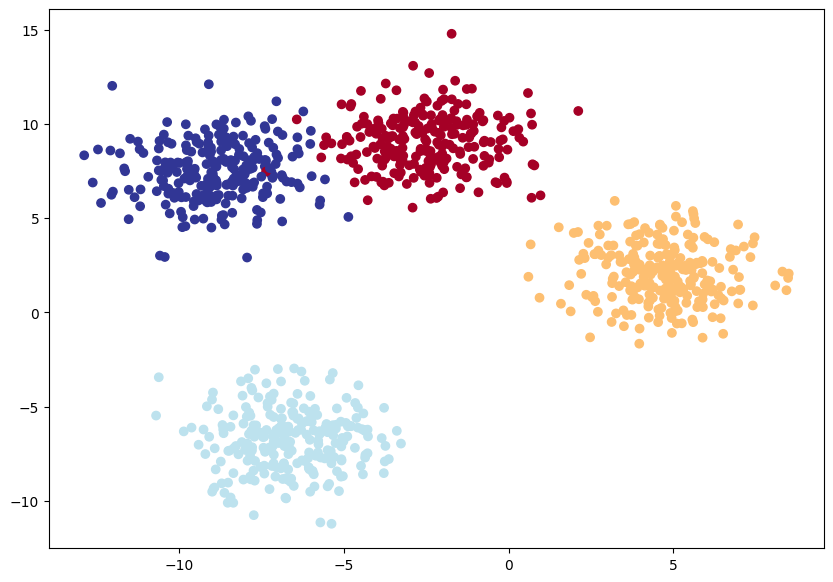

In [342]:
# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [343]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features = hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features = output_features),
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

In [344]:
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)

In [345]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters())

In [346]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [347]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [348]:
epochs = 200

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(0,epochs + 1):
    
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # Escolhe a classe com maior probabilidade

    loss = loss_fn(y_logits, y_blob_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_4.eval()

    if (epoch % 10 == 0):
        with torch.inference_mode():
            test_logits = model_4(X_blob_test)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

            acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

            print(f"epoch: {epoch:<3} | acc = {acc:.2f}")

epoch: 0   | acc = 65.50
epoch: 10  | acc = 68.38
epoch: 20  | acc = 70.12
epoch: 30  | acc = 71.38
epoch: 40  | acc = 71.75
epoch: 50  | acc = 72.50
epoch: 60  | acc = 73.12
epoch: 70  | acc = 73.25
epoch: 80  | acc = 73.50
epoch: 90  | acc = 74.88
epoch: 100 | acc = 78.12
epoch: 110 | acc = 83.75
epoch: 120 | acc = 88.25
epoch: 130 | acc = 90.50
epoch: 140 | acc = 93.00
epoch: 150 | acc = 94.75
epoch: 160 | acc = 95.88
epoch: 170 | acc = 96.62
epoch: 180 | acc = 96.88
epoch: 190 | acc = 97.12
epoch: 200 | acc = 97.75


In [349]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

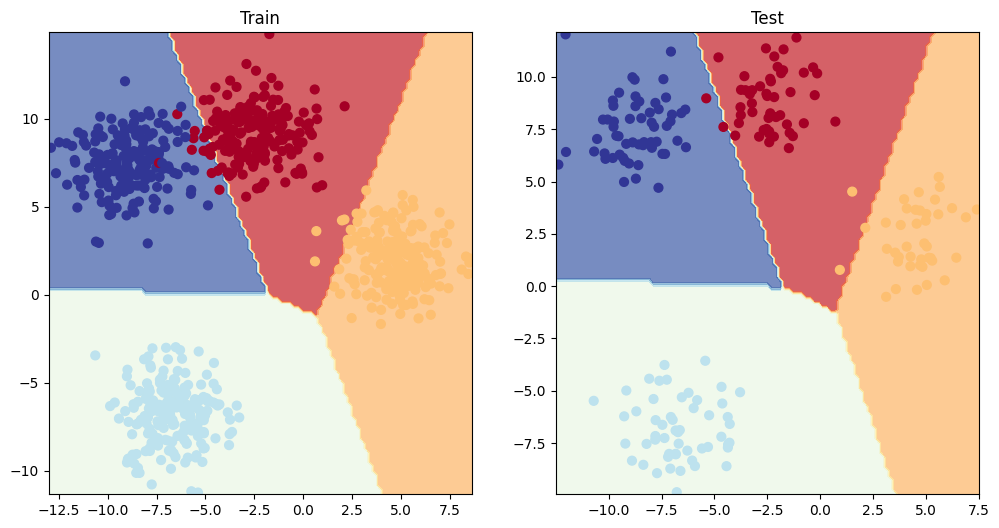

In [350]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)